# 4. Finite difference methods
This notebook demonstrates solving the 1D Burgers equation using finite differences with three-point backward differences (BDF2) and a non-uniform grid, more closely spaced around $x=0$.

We'll go over the following:
- How I apply a finite-difference method to the 1D Burgers equation
- Some example results from my implementation

A more thorough study of the performance is saved for the comparison between methods.


In [1]:
using Pkg
Pkg.activate("..") # activate BurgersJoint environment
Pkg.instantiate() # install all dependencies if necessary
using BurgersJoint
using BurgersJoint.BurgersEquation
using BurgersJoint.FiniteDifference
using Plots

  Activating project at `~/Documents/ACFPD/Individual assignment/BurgersJoint`
Precompiling project...
  14099.3 ms  ✓ BurgersJoint
  1 dependency successfully precompiled in 17 seconds. 621 already precompiled.


## Finite difference method applied to the 1D Burgers equation

In Basdevant1986, the description of their finite difference method essentially constitutes providing the below expression for the coordinate transformation and mentioning that a three-point backward scheme is used. They refer to a paper "Direct simulation of burgulence" by Orlandi and Briscolini (1983) for the details of the scheme. I have not been able to find this paper anywhere, so aside from the coordinate transformation, the rest of the implementation is based on my own understanding.

### Coordinate transformation

Like Basdevant1986, we will employ the following coordinate transformation to generate a grid that is more closely spaced in the high-gradient region around $x=0$:
$$
x = g(\zeta) = 
\begin{cases}
-1 + \frac{\tanh(2S \zeta)}{\tanh(S)},     & \text{for } \zeta \in [0,0.5[ \\
1 + \frac{\tanh(2S (\zeta-1))}{\tanh(S)},  & \text{for } \zeta \in [0.5,1]
\end{cases}
$$
with stretching parameter $S$. The values of $\zeta$ are evenly spaced between 0 and 1. When $S=0$, the $x$ grid is almost uniform. As $S$ increases, the grid becomes more concentrated around $x=0$ as the following figure illustrates:

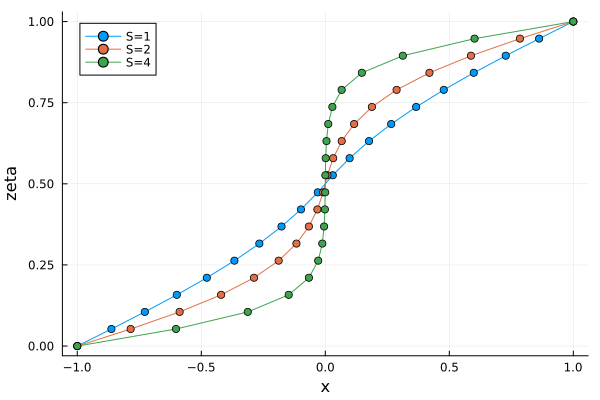

In [2]:
# Plot x vs zeta for different S values
N = 20
zeta = range(0.0, 1.0, length=N)
x = Array{Float64}(undef, N)
plt = plot()
for S in [1, 2, 4]
    for j in eachindex(zeta)
        if zeta[j] >= 0.5
            x[j] = 1 + tanh(2S*(zeta[j] - 1)) / tanh(S)
        else
            x[j] = -1 + tanh(2S*zeta[j]) / tanh(S)
        end
    end
    plot!(plt, x, zeta, label="S=$S", xlabel="x", ylabel="zeta", 
          marker=:circle, markersize=4, linewidth=1)
end
display(plt)


The transformation is continuous and differentiable. The Jacobian is given by
$$
\frac{\partial x}{\partial \zeta} = g'(\zeta) =
\begin{cases}
\frac{2S\ \text{sech}^2(2S \zeta)}{\tanh(S)},     & \text{for } \zeta \in [0,0.5[ \\
\frac{2S\ \text{sech}^2(2S (\zeta-1))}{\tanh(S)},  & \text{for } \zeta \in [0.5,1]
\end{cases}
$$
and the Hessian is given by
$$
\frac{\partial^2 x}{\partial \zeta^2} = g''(\zeta) =
\begin{cases}
-\frac{8S^2\ \text{sech}^2(2S \zeta) \tanh(2S \zeta)}{\tanh(S)},     & \text{for } \zeta \in [0,0.5[ \\
-\frac{8S^2\ \text{sech}^2(2S (\zeta-1)) \tanh(2S (\zeta-1))}{\tanh(S)},  & \text{for } \zeta \in [0.5,1]
\end{cases}.
$$

### Derivatives wrt. $x$ with finite differences

Using the chain rule, we can express the $x$ derivative of a function $u(x)$ in terms of the derivative with respect to $\zeta$:
$$
\frac{\partial u}{\partial x} = \frac{\partial \zeta}{\partial x} \frac{\partial u}{\partial \zeta} = \frac{1}{g'(\zeta)} \frac{\partial u}{\partial \zeta},
$$
which can be approximated by centered differences with uniform spacing $\Delta \zeta$:
$$
\frac{\partial u_i}{\partial x}=\frac{1}{g'_i} \frac{u_{i+1} - u_{i-1}}{2\Delta \zeta},
$$
For the second derivative wrt. $x$, we can use the chain rule again:
$$
\frac{\partial^2 u}{\partial x^2} 
= \frac{\partial}{\partial x}\left(\frac{\partial u}{\partial x}\right)
=  \frac{\partial\zeta}{\partial x} \frac{\partial}{\partial \zeta} \left(\frac{\partial u}{\partial x}\right) 
=  \frac{1}{g'(\zeta)} \frac{\partial}{\partial \zeta} \left(\frac{\partial u}{\partial x}\right) 
=   \frac{1}{g'(\zeta)} \frac{\partial}{\partial \zeta} \left(\frac{1}{g'(\zeta)} \frac{\partial u}{\partial \zeta}\right) 
$$
Using that
$$
\frac{\partial}{\partial \zeta}\left(\frac{1}{g'}\right) = - \frac{g''}{(g')^2},
$$
the product rule gives

$$
\frac{\partial^2 u}{\partial x^2} = \frac{1}{(g')^2} \frac{\partial^2 u}{\partial \zeta^2} - \frac{g''}{(g')^3} \frac{\partial u}{\partial \zeta} 
$$

Centered differences for the first and second derivatives wrt. $\zeta$ gives
$$
\frac{\partial u_i}{\partial \zeta} = \frac{u_{i+1} - u_{i-1}}{2\Delta \zeta}, \quad
\frac{\partial^2 u_i}{\partial \zeta^2} = \frac{u_{i+1} - 2u_i + u_{i-1}}{(\Delta \zeta)^2}
$$
Substituting these into the above expression gives
$$
\frac{\partial^2 u_i}{\partial x^2} = \frac{1}{(g_i')^2} \frac{u_{i+1} - 2u_i + u_{i-1}}{(\Delta \zeta)^2} - \frac{g_i''}{(g_i')^3} \frac{u_{i+1} - u_{i-1}}{2\Delta \zeta}
$$

I didn't have time to implement this expression, so for now I will use the following simpler expression for the second derivative:
$$
\frac{\partial^2 u_i}{\partial x^2} = \frac{2}{\Delta x_i + \Delta x_{i-1}} \left(\frac{u_{i+1} - u_i}{\Delta x_i} - \frac{u_i - u_{i-1}}{\Delta x_{i-1}}\right),
$$
where $\Delta x_i$ is simply found as the distance between neighboring grid points:
$$
\Delta x_i = \frac{x_{i+1} - x_i}{2}
$$

### Time discretization

I use two backward differentiation formulas (BDFs) to discretize the time derivative For bootstrapping, I apply the first-order BDF (BDF1) to Burgers' equation:
$$
\frac{u^1-u^0}{\Delta t}+u^0\left(\frac{\partial u^1}{\partial x}\right)=\nu \frac{\partial^2 u^1}{\partial x^2}
$$
where $u^n$ is the value of $u$ at time $t^n=n\Delta t$. Note here that the advection is linearized by using the value of $u$ at the previous time step $t^0$.

Given a known $u^0$ and the discretizations of the spatial derivatives, this can be written as a linear system of equations:
$$
\mathbf{b}(\mathbf{u}^0) = \mathbf{A} \mathbf{u}^1,
$$
where the exact expressions for $\mathbf{b}$ and $\mathbf{A}$ can be found in the implementation. As we used a three-point scheme for the spatial derivatives $\mathbf{A}$ is a tridiagonal matrix. The system can thus simply be solved by:
$$
\mathbf{u}^1 = \mathbf{A}^{-1} \mathbf{b}(\mathbf{u}^0),
$$
where $\mathbf{A}^{-1}$ can be computed using Thomas' algorithm.

For subsequent steps, I use the second-order BDF (BDF2) on Burgers' equation:
$$
\frac{3 u^n-4 u^{n-1}+u^{n-2}}{2 \Delta t}+u^{n-1}\left(\frac{\partial u^n}{\partial x}\right)=\nu \frac{\partial^2 u^{n}}{\partial x^2},
$$
where the advection term is now linearized using the value of $u$ at the previous time step $t^{n-1}$. This can be written as a linear system of equations:
$$
\mathbf{b}(\mathbf{u}^{n-1},\mathbf{u}^{n-2}) = \mathbf{A} \mathbf{u}^n,
$$
where expressions for $\mathbf{b}$ and $\mathbf{A}$ are different from BDF1 (see implementation) but still tridiagonal. The system can thus be solved in the same way as above:
$$
\mathbf{u}^n = \mathbf{A}^{-1} \mathbf{b}(\mathbf{u}^{n-1},\mathbf{u}^{n-2}),
$$

## Summary of the algorithm

1. Set up the grid using the coordinate transformation
2. Set up the tridiagonal matrix $\mathbf{A}$ and the right-hand side $\mathbf{b}$
3. Use BDF1 to compute $u^1$ from $u^0$
4. Time-stepping using BDF2 to compute $u^n$ from $u^{n-1}$ and $u^{n-2}$

## Example results
Let us look at a few example solutions using the Fourier spectral methods. We will use the following parameters unless otherwise specified:
- Domain $x\in[-1,1]$
- Viscosity $\nu = 10^{-2}/\pi$
- Initial condition $u(x,0) = -\sin(x)$
- Number of grid points - 1: $N = 32$
- Time step $\Delta t = 0.001$
- Total time $T = 4/\pi$

In [13]:
# Parameter choices:
N   = 32    # number of grid points
dt   = 1e-3
T = 4/pi    # final time
dt_snapshot = 1/pi

x, u_final, snapshot_times, snapshots = solveFiniteDifference(N;dt=dt, T=T, dt_snapshot=dt_snapshot)

([-1.0, -0.7473462250598857, -0.5249745313288203, -0.35020286807680323, -0.22466759325868457, -0.14021234100433766, -0.08586791653358117, -0.05189403922820368, -0.03103690880640575, -0.018374713838394507  …  0.018374713838394507, 0.03103690880640575, 0.05189403922820368, 0.08586791653358117, 0.14021234100433777, 0.22466759325868457, 0.3502028680768031, 0.5249745313288201, 0.7473462250598859, 1.0], [0.0, 0.16260138092082344, 0.30329618082162724, 0.41107868304972983, 0.4862625441731141, 0.5355219667251002, 0.5672818349256493, 0.5857727259727405, 0.5999153451625446, 0.5885595304216262  …  -0.588559530421636, -0.5999153451625461, -0.5857727259727439, -0.5672818349256532, -0.535521966725102, -0.48626254417311676, -0.4110786830497313, -0.30329618082162607, -0.1626013809208247, 0.0], [0.0, 0.318, 0.637, 0.9550000000000001, 1.2730000000000001], [[0.0, 0.7129773443374345, 0.9969236082261097, 0.8912956844582021, 0.6486536126092263, 0.426382796901451, 0.26650206685424854, 0.16230870266477948, 0.0

Plot numerical solution versus analytical solution at different times:

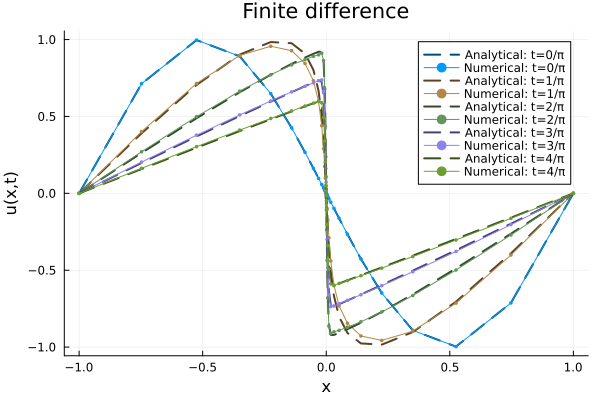

In [14]:
function plot_sol(method_name)
    plt = plot(title="$method_name", xlabel="x", ylabel="u(x,t)")
    pal = palette(:auto, length(snapshot_times))  # get default palette colors

    # Darken the analytical color by reducing brightness
    f = 0.5

    for (i, t) in enumerate(snapshot_times)
          num_color = pal[i]
          analytical_color = RGB(num_color.r * f, num_color.g * f, num_color.b * f)
          plot!(plt, x, analytical_solution(x, t), label="Analytical: t=$(i-1)/π", lw=2, linestyle=:dash, color=analytical_color)
          plot!(plt, x, snapshots[i], label="Numerical: t=$(i-1)/π", lw=1, color=num_color, marker=:circle, markersize=2, markerstrokewidth=0)
    end

    display(plt)
end

plot_sol("Finite difference")

We see that even with a relatively coarse grid, the solution is very close to the analytical solution. This is probably in part due to the coordinate transformation concentrating grid-points around the high-gradient region. The numerical solution appears slightly more diffusive than the analytical solution. That could be due to the finite difference scheme or the coordinate transformation, but would require further investigation to determine.

#### Different grid spacings

A quick qualitative test of the effect of spatial and temporal grid spacings on the solution:

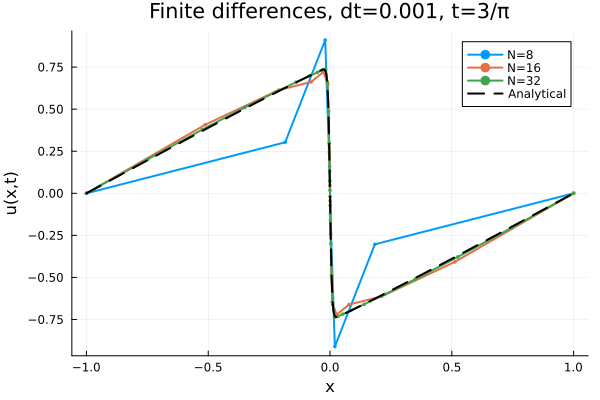

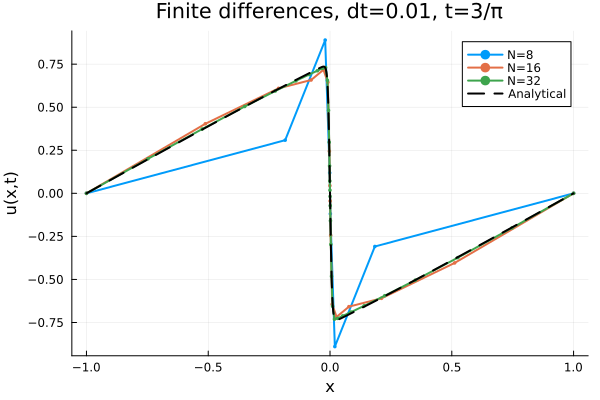

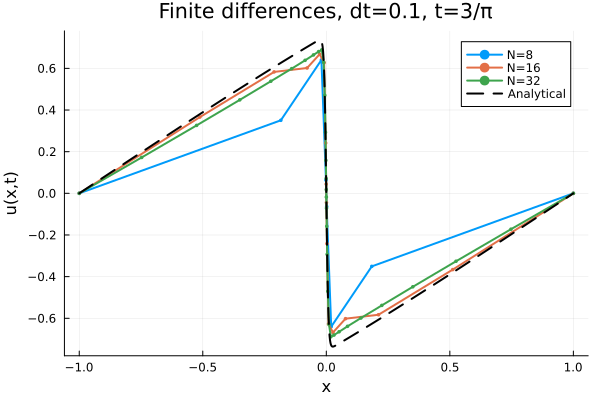

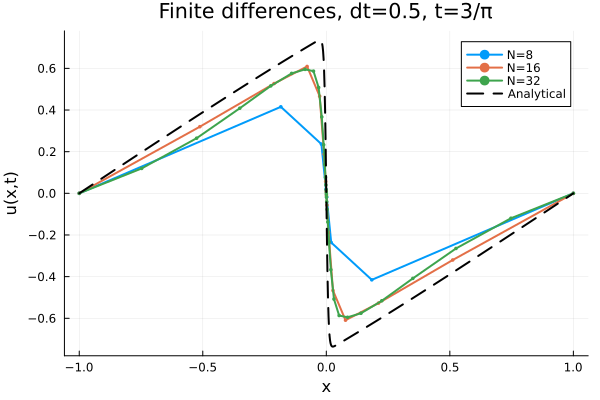

In [24]:
T = 3/pi
N_list = [8, 16, 32]
dt_list = [0.001, 0.01, 0.1, 0.5]

for dt in dt_list
    plt = plot(title="Finite differences, dt=$dt, t=3/π", xlabel="x", ylabel="u(x,t)")
    for N in N_list
        x, u_final, _, _ = solveFiniteDifference(N; dt=dt, T=T)
        plot!(plt, x, u_final, label="N=$N", lw=2, marker=:circle, markersize=2, markerstrokewidth=0)
    end
    x = range(-1, 1, length=1000)
    plot!(plt, x, analytical_solution(x, T), label="Analytical", lw=2, linestyle=:dash,color=:black)
    display(plt)
end

Compared to Fourier and Chebyshev methods studied previously, we see that it takes extremely coarse grids (in both space and time) to start to lose accuracy. It could be that the coordinate transformation is helping with this, which would have to be investigated further. The BDF2 method is implicit and therefore likely more stable than the explicit methods used previously.